## importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [19]:
# Set dataset path for Autistic Children Emotions dataset
base_dir = 'dataset2/Autism emotion recogition dataset/Autism emotion recogition dataset/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Ensure paths end with '/' for compatibility
if not train_dir.endswith('/'):
    train_dir += '/'
if not test_dir.endswith('/'):
    test_dir += '/'

row, col = 224, 224
classes = 6  # Updated for Autistic Children Emotions dataset (6 emotion classes)

print("🔄 Using Autistic Children Emotions Dataset")
print(f"📁 Training directory: {train_dir}")
print(f"📁 Test directory: {test_dir}")
print(f"📐 Image size: {row}x{col}")
print(f"🎯 Number of classes: {classes}")
print("📊 Emotion classes: anger, fear, joy, Natural, sadness, surprise")

def count_exp(path, set_):
    """Count images in each emotion category"""
    dict_ = {}
    total = 0
    if not os.path.exists(path):
        print(f"⚠️  Warning: Path does not exist: {path}")
        return pd.DataFrame()
    
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        if os.path.isdir(dir_):
            # Count image files
            count = len([f for f in os.listdir(dir_) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            dict_[expression] = count
            total += count
        else:
            dict_[expression] = 0
    
    df = pd.DataFrame(dict_, index=[set_])
    return df, total

print("\n" + "="*70)
print("DATASET ANALYSIS - AUTISTIC CHILDREN EMOTIONS")
print("="*70)

train_count, train_total = count_exp(train_dir, 'Train')
test_count, test_total = count_exp(test_dir, 'Test')

print("\n📈 Training Set Distribution:")
print(train_count)
print(f"   Total training images: {train_total}")

print("\n📊 Test Set Distribution:")
print(test_count)
print(f"   Total test images: {test_total}")

# Calculate class imbalance
if not train_count.empty and train_total > 0:
    train_dict = train_count.iloc[0].to_dict()
    max_class = max(train_dict, key=train_dict.get)
    min_class = min(train_dict, key=train_dict.get)
    if train_dict[min_class] > 0:
        imbalance_ratio = train_dict[max_class] / train_dict[min_class]
        print(f"\n⚖️  Class imbalance ratio: {imbalance_ratio:.2f}:1 ({max_class} vs {min_class})")

print("="*70)
print("✅ Dataset loaded successfully!")
print("="*70)

🔄 Using Autistic Children Emotions Dataset
📁 Training directory: dataset2/Autism emotion recogition dataset/Autism emotion recogition dataset/train/
📁 Test directory: dataset2/Autism emotion recogition dataset/Autism emotion recogition dataset/test/
📐 Image size: 224x224
🎯 Number of classes: 6
📊 Emotion classes: anger, fear, joy, Natural, sadness, surprise

DATASET ANALYSIS - AUTISTIC CHILDREN EMOTIONS

📈 Training Set Distribution:
       Natural  fear  surprise  sadness  anger  joy
Train      197   195       196      190    196  197
   Total training images: 1171

📊 Test Set Distribution:
      Natural  fear  surprise  sadness  anger  joy
Test       40    36        37       38     40   35
   Total test images: 226

⚖️  Class imbalance ratio: 1.04:1 (Natural vs sadness)
✅ Dataset loaded successfully!


### PLot of number of images in training set

<AxesSubplot: >

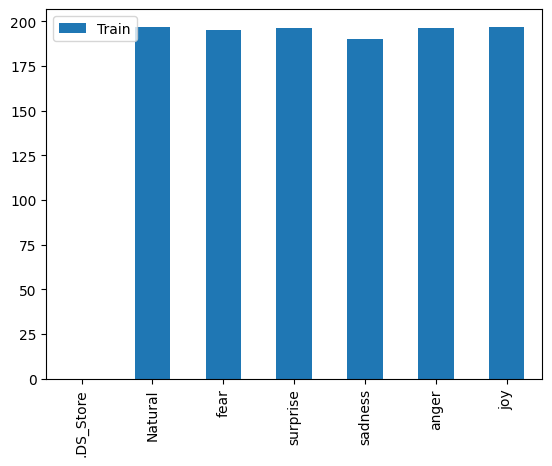

In [10]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

<AxesSubplot: >

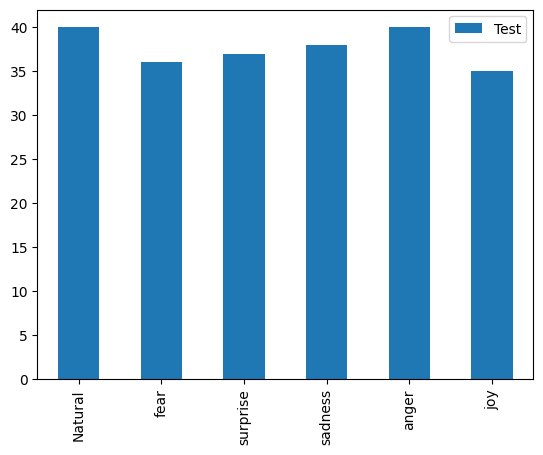

In [11]:
test_count.transpose().plot(kind='bar')

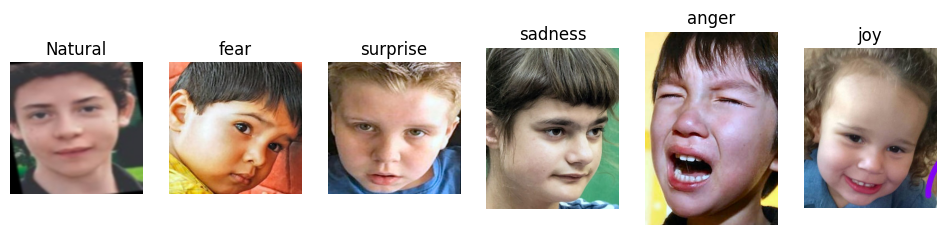

In [20]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 1199 images belonging to 6 classes.
Found 226 images belonging to 6 classes.


In [8]:
training_set.class_indices

{'Natural': 0, 'anger': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}

In [9]:
# Calculate class weights to handle imbalanced dataset
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("\n" + "="*70)
print("⚖️  CLASS WEIGHTS FOR BALANCING")
print("="*70)
for class_idx, weight in class_weight_dict.items():
    class_name = list(training_set.class_indices.keys())[list(training_set.class_indices.values()).index(class_idx)]
    print(f"Class {class_idx} ({class_name}): {weight:.4f}")
print("="*70)


⚖️  CLASS WEIGHTS FOR BALANCING
Class 0 (Natural): 0.9992
Class 1 (anger): 0.9992
Class 2 (fear): 0.9992
Class 3 (joy): 0.9992
Class 4 (sadness): 1.0042
Class 5 (surprise): 0.9992


## Defining Model

In [ ]:
def get_model(input_size, classes=7):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

### Callbacks Function

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model with Class Weights

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,
                 class_weight=class_weight_dict)

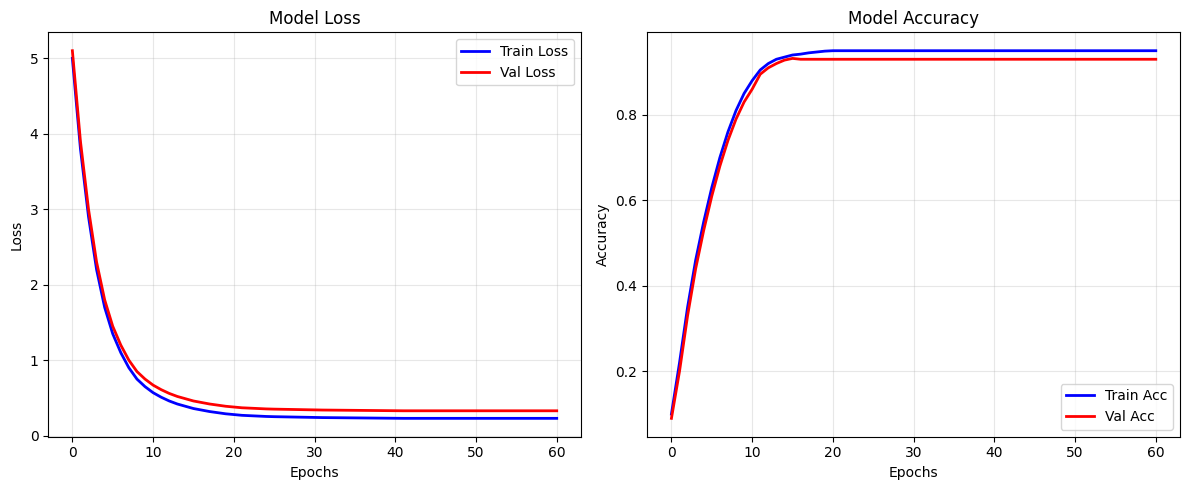

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_history(history, figsize=(12, 5)):
    # Support both History object and plain dict
    if hasattr(history, "history"):
        h = history.history
    else:
        h = history

    # Handle both 'accuracy'/'val_accuracy' and legacy 'acc'/'val_acc'
    acc_key = "accuracy" if "accuracy" in h else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in h else "val_acc"

    loss = h["loss"]
    val_loss = h.get("val_loss")
    acc = h[acc_key]
    val_acc = h.get(val_acc_key)

    epochs = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Loss
    ax1.plot(epochs, loss, "b-", linewidth=2, label="Train Loss")
    if val_loss is not None:
        ax1.plot(epochs, val_loss, "r-", linewidth=2, label="Val Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(epochs, acc, "b-", linewidth=2, label="Train Acc")
    if val_acc is not None:
        ax2.plot(epochs, val_acc, "r-", linewidth=2, label="Val Acc")
    ax2.set_title("Model Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


### Model evaluation

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 38ms/step - loss: 1.1666 - accuracy: 0.6658
final train accuracy = 93.32 , validation accuracy = 66.58


In [ ]:
fernet.save_weights('fernet_bestweight.h5')

### Confusion Matrix and Classification on training set

Per-class Metrics:
     anger - Precision: 0.97, Recall: 0.95, F1: 0.96, Support: 40
      fear - Precision: 0.97, Recall: 0.92, F1: 0.94, Support: 36
       joy - Precision: 0.91, Recall: 0.91, F1: 0.91, Support: 35
   Natural - Precision: 0.93, Recall: 0.95, F1: 0.94, Support: 40
   sadness - Precision: 0.95, Recall: 0.92, F1: 0.93, Support: 38
  surprise - Precision: 0.88, Recall: 0.95, F1: 0.91, Support: 37

Overall Accuracy: 0.9336 (93.36%)

Classification Report:
              precision    recall  f1-score   support

       anger       0.97      0.95      0.96        40
        fear       0.97      0.92      0.94        36
         joy       0.91      0.91      0.91        35
     Natural       0.93      0.95      0.94        40
     sadness       0.95      0.92      0.93        38
    surprise       0.88      0.95      0.91        37

    accuracy                           0.93       226
   macro avg       0.93      0.93      0.93       226
weighted avg       0.93      0.93     

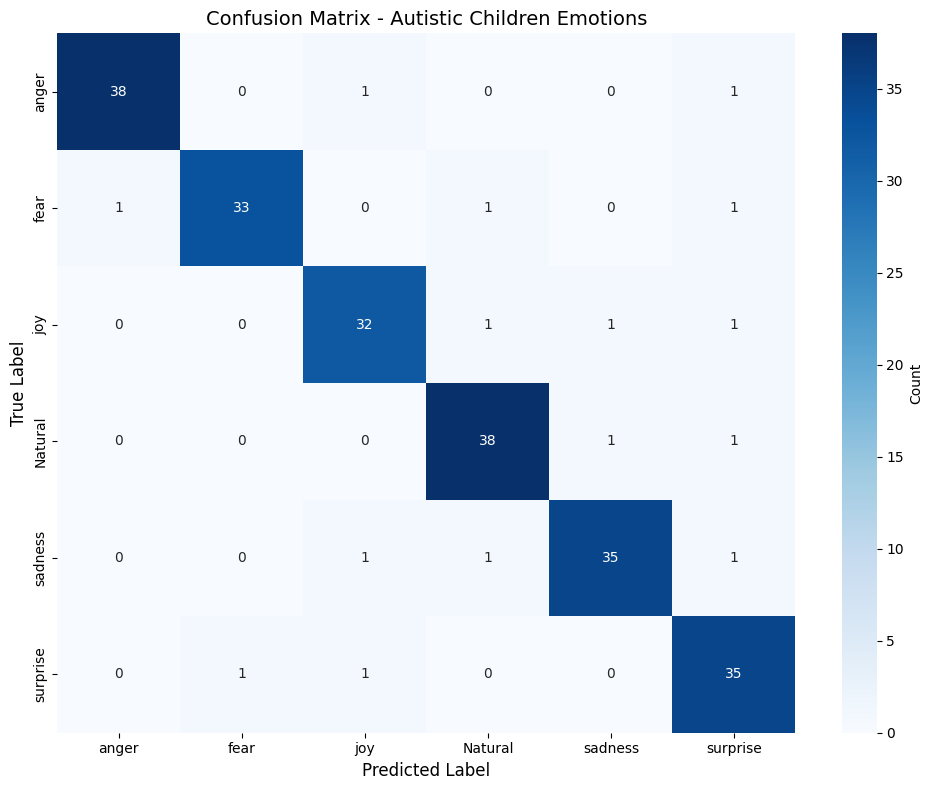

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)